Importação dos pacotes necessários

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
from fredapi import Fred
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from collections import OrderedDict
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller, kpss, bds
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import skewtest, kurtosistest, skew, kurtosis, boxcox
from pathlib import Path
import os
os.environ['OMP_NUM_THREADS'] = '1'

In [4]:
import optuna

Criação/carregamento do ficheiro de armazenamento de corridas de optuna

In [5]:
optuna_storage_path = "optuna_journal_storage.log"
lock_obj = optuna.storages.journal.JournalFileOpenLock(optuna_storage_path)
storage = optuna.storages.JournalStorage(
    optuna.storages.journal.JournalFileBackend(optuna_storage_path, lock_obj=lock_obj)
)

In [6]:
import logging
cmdstanpy_logger = logging.getLogger("cmdstanpy")
cmdstanpy_logger.disabled = True

# Importação do **darts**

O darts é uma biblioteca de python para timeseries, com o intuito de simplificar e agilizar o processo de análise e modelação de séries temporais.

In [7]:
from darts import TimeSeries
from darts.utils import statistics
from darts.metrics import mape
from darts.utils.utils import ModelMode, SeasonalityMode

Para aceder a séries temporais do FRED (fred.stlouisfed.org) ao vivo, utilizamos uma API Key pessoal.

In [8]:
fred = Fred(api_key="8ede227d95e33c5cdf2ea8a83577bc0a")

Séries temporais escolhidas:

In [9]:
fred_series_ids = ["IHLIDXNSAGB", "IRLTLT01GBM156N", "QGBN628BIS", "UKNGDP", "GBRCPIALLMINMEI"]

In [10]:
fred_series_metadata = []
fred_series_list = []
for series in fred_series_ids:
    metadata = fred.get_series_info(series)
    series = fred.get_series(series).rename(metadata["title"])
    fred_series_metadata.append(metadata)
    fred_series_list.append(series)

Dados extra: Incerteza com políticas económicas no Reino Unido com periodicidade diária não existe no FRED

In [11]:
economic_uncertainty = pd.read_csv("../data/UK_Daily_Policy_Data.csv")

In [12]:
economic_uncertainty["date"] = pd.to_datetime(economic_uncertainty.drop("daily_policy_index", axis=1))
economic_uncertainty = economic_uncertainty.drop(["day", "month", "year"], axis=1).set_index("date").squeeze()

In [13]:
economic_uncertainty

date
2001-01-01     50.70
2001-01-02    110.77
2001-01-03    179.41
2001-01-04    183.22
2001-01-05     89.31
               ...  
2025-04-26    287.84
2025-04-27    340.04
2025-04-28    418.48
2025-04-29    255.07
2025-04-30    367.90
Name: daily_policy_index, Length: 8886, dtype: float64

In [14]:
data = fred_series_list.copy()
data.append(economic_uncertainty)

In [15]:
# Conversão para formato time series suportado pelo darts
data_ts = [TimeSeries.from_series(series) for series in data]

In [16]:
# Teste de sazonalidade 
[statistics.check_seasonality(series, max_lag=365) for series in data_ts]

[(False, 0), (False, 0), (False, 0), (False, 0), (False, 0), (True, 7)]

# Time Series Forecasting

In [17]:
[print(str(idx) + " " + series.title) for idx, series in enumerate(fred_series_metadata)]
print(str(len(data_ts) - 1) + " " + "UK_Daily_Policy_Data")

0 Job Postings on Indeed in the United Kingdom
1 Interest Rates: Long-Term Government Bond Yields: 10-Year: Main (Including Benchmark) for United Kingdom
2 Residential Property Prices for United Kingdom
3 Gross Domestic Product for United Kingdom
4 Consumer Price Indices (CPIs, HICPs), COICOP 1999: Consumer Price Index: Total for United Kingdom
5 UK_Daily_Policy_Data


In [18]:
series_names = ["Job_Postings", "Interest_Rates", "Residential_Property_Prices", "GDP", "CPI", "Economic_Uncertainty"]

#### **Escolher série temporal para modelar**

In [19]:
series_chosen_id = 0

In [20]:
series = data_ts[series_chosen_id]
series_name = series_names[series_chosen_id]

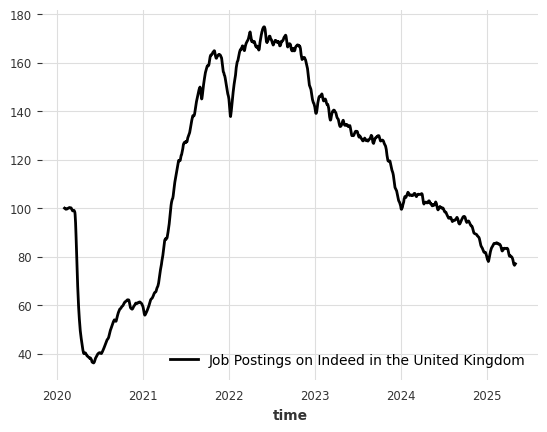

In [21]:
series.plot()
plt.show()

splitting: proporção da série usar para treino de modelos, o resto é usado para validação  
1 - visualizing: proporção da série que queremos visualizar

In [22]:
splitting = 0.95
visualizing = 0.9

In [23]:
train, val = series.split_before(splitting)

## Primeiro modelo - Error Trend Seasonality

No pacote **darts**, a família de modelos de ETS encontram-se no módulo de Exponential Smoothing, com os parâmetros _trend_  e _seasonal_.

In [24]:
from darts.models import ExponentialSmoothing

model = ExponentialSmoothing(trend=ModelMode.ADDITIVE, 
                             seasonal=SeasonalityMode.ADDITIVE)
model.fit(train)
prediction = model.predict(len(val))

In [25]:
len(series)

1918

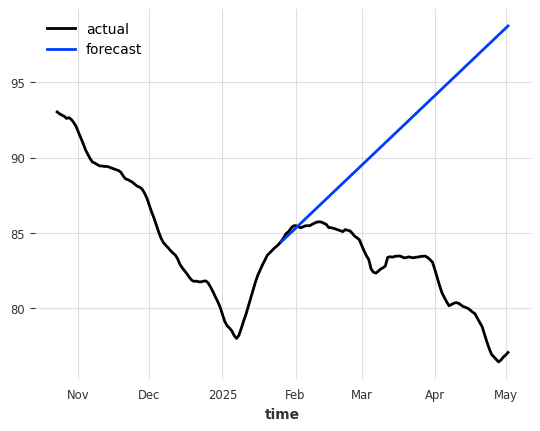

In [26]:
series.drop_before(visualizing).plot(label="actual")  # plot only last 1-visualizing of series
prediction.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.show()

## Segundo modelo - Família ARIMA

Neste segmento exploramos a seleção de modelos automática providenciada pelo **darts/statsforecast**.  


Critério selecionado: "BIC"

In [27]:
from darts.models import AutoARIMA

print(f"Information Criteria: {(ic:='bic')}")
model_aarima = AutoARIMA(trace=True, ic=ic, seasonal=True)
model_aarima = model_aarima.fit(train)
prediction_aarima = model_aarima.predict(len(val))

Information Criteria: bic

ARIMA(2,2,2)                   :inf

ARIMA(0,2,0)                   :-1576.0408951297502

ARIMA(1,2,0)                   :-1572.9572920349783

ARIMA(0,2,1)                   :-1572.4655852511605

ARIMA(1,2,1)                   :-1571.2018590318287
Now re-fitting the best model(s) without approximations...


ARIMA(0,2,0)                   :-1576.0408951297502


phi = p  
theta = q   
delta = d  

In [28]:
model_aarima.model.model_

{'coef': {},
 'sigma2': 0.02452686088491465,
 'var_coef': None,
 'mask': array([], dtype=bool),
 'loglik': 791.7734686541341,
 'aic': -1581.5469373082683,
 'arma': (0, 0, 0, 0, 1, 2, 0),
 'residuals': array([ 0.04472136, -0.13438731,  0.07      , ..., -0.02      ,
        -0.02      ,  0.02      ]),
 'code': 0,
 'n_cond': 0,
 'nobs': 1819,
 'model': {'phi': array([], dtype=float64),
  'theta': array([], dtype=float64),
  'delta': array([ 2., -1.]),
  'Z': array([ 1.,  2., -1.]),
  'a': array([2.000e-02, 8.411e+01, 8.398e+01]),
  'P': array([[-6.66133815e-16,  3.15936926e-16,  7.03328715e-17],
         [ 3.15936926e-16, -1.57968463e-16, -5.24447100e-32],
         [ 7.03328715e-17, -5.24447100e-32,  7.03328715e-17]]),
  'T': array([[ 0.,  0.,  0.],
         [ 1.,  2., -1.],
         [ 0.,  1.,  0.]]),
  'V': array([[1., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]),
  'h': 0.0,
  'Pn': array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00, -1.579

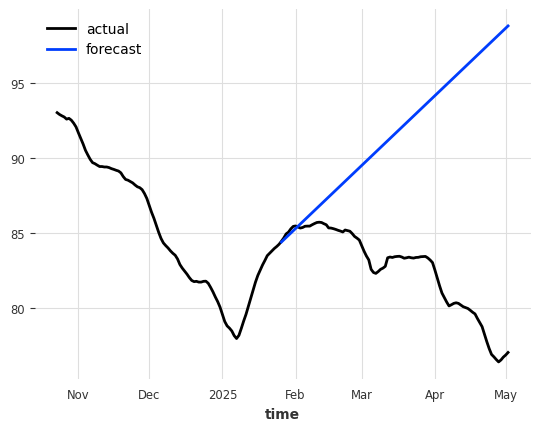

In [29]:
series.drop_before(visualizing).plot(label="actual")  # plot only last 5% of series
prediction_aarima.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.show()

Os modelos ARIMA, quando projetados para um futuro acima da ordem da componente de média móvel, as previsões alinham-se numa reta.

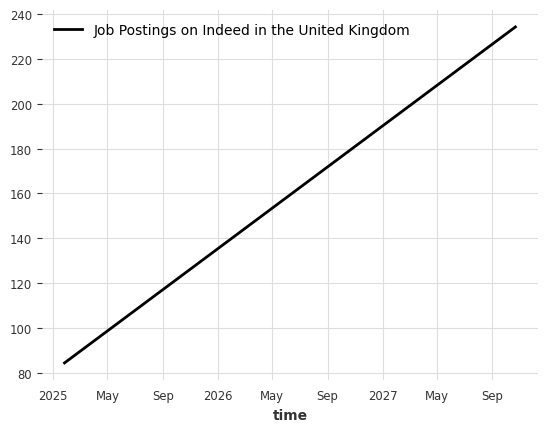

In [30]:
model_aarima.predict(1000).plot()
plt.show()

In [31]:
# add part about naive ma model here

In [32]:
from darts.models import NaiveSeasonal, Prophet, AutoETS, AutoARIMA

In [33]:
base_model = NaiveSeasonal(K=1)
base_model.model_name = "Baseline"

In [34]:
default_aets = AutoETS()
default_aets.model_name = "AutoETS"

default_aarima = AutoARIMA()
default_aarima.model_name = "AutoARIMA"

default_prophet = Prophet(country_holidays="GB", suppress_stdout_stderror=True)
default_prophet.model_name = "Prophet"

default_models = [default_aets, default_aarima, default_prophet]

In [35]:
def backtest_models(series: TimeSeries, val_series: TimeSeries=val, models: list=default_models, horizons: list=[1, 3, 7], points_to_test: int=100, verbose=True, retrain=True, baseline=base_model):
    backtest_results = dict()
    if baseline:
        models = [baseline, *models]
    for horizon in sorted(horizons):
        print(f"Backtesting {horizon} {series.freq} horizon")
        backtests = []
        for model in models:
            if model.model_name == "Baseline":
                backtest = model.historical_forecasts(
                    series,
                    start=len(series) - points_to_test,
                    forecast_horizon=horizon,
                    retrain=True,
                    verbose=False,
                )
            else:
                print(f"Backtesting {model.model_name}")
                backtest = model.historical_forecasts(
                    series,
                    start=len(series) - points_to_test,
                    forecast_horizon=horizon,
                    verbose=verbose,
                    retrain=retrain,
                )
            backtests.append(backtest)
        backtest_results[horizon] = {model.model_name: (backtests[i], mape(series, backtests[i])) for i, model in enumerate(models)}
    return backtest_results

In [36]:
def plot_backtest_results(series: TimeSeries, backtest_results: dict, points_to_test: int=100):
    for horizon, model in backtest_results.items():
        series.drop_before(len(series) - 2*points_to_test).plot(label='data')
        for model_name, (backtest, mape) in model.items():
            backtest.plot(lw=3, label=f'{model_name}, MAPE={mape:.2f}%')
        plt.title(f'Backtests with {horizon} {series.freq} forecast horizon')
        plt.legend()
        plt.show()

In [37]:
horizons = [1, 3, 7, 15, 30]

In [38]:
results = backtest_models(series, horizons=horizons)

Backtesting 1 <Day> horizon
Backtesting AutoETS


historical forecasts:   0%|          | 0/100 [00:00<?, ?it/s]

Backtesting AutoARIMA


historical forecasts:   0%|          | 0/100 [00:00<?, ?it/s]

Backtesting Prophet


historical forecasts:   0%|          | 0/100 [00:00<?, ?it/s]

Backtesting 3 <Day> horizon
Backtesting AutoETS


historical forecasts:   0%|          | 0/98 [00:00<?, ?it/s]

Backtesting AutoARIMA


historical forecasts:   0%|          | 0/98 [00:00<?, ?it/s]

Backtesting Prophet


historical forecasts:   0%|          | 0/98 [00:00<?, ?it/s]

Backtesting 7 <Day> horizon
Backtesting AutoETS


historical forecasts:   0%|          | 0/94 [00:00<?, ?it/s]

Backtesting AutoARIMA


historical forecasts:   0%|          | 0/94 [00:00<?, ?it/s]

Backtesting Prophet


historical forecasts:   0%|          | 0/94 [00:00<?, ?it/s]

Backtesting 15 <Day> horizon
Backtesting AutoETS


historical forecasts:   0%|          | 0/86 [00:00<?, ?it/s]

Backtesting AutoARIMA


historical forecasts:   0%|          | 0/86 [00:00<?, ?it/s]

Backtesting Prophet


historical forecasts:   0%|          | 0/86 [00:00<?, ?it/s]

Backtesting 30 <Day> horizon
Backtesting AutoETS


historical forecasts:   0%|          | 0/71 [00:00<?, ?it/s]

Backtesting AutoARIMA


historical forecasts:   0%|          | 0/71 [00:00<?, ?it/s]

Backtesting Prophet


historical forecasts:   0%|          | 0/71 [00:00<?, ?it/s]

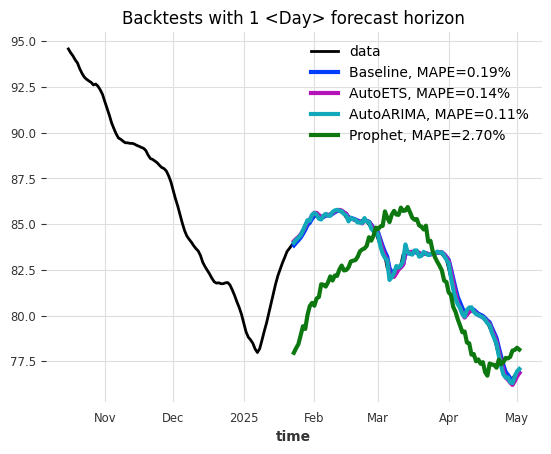

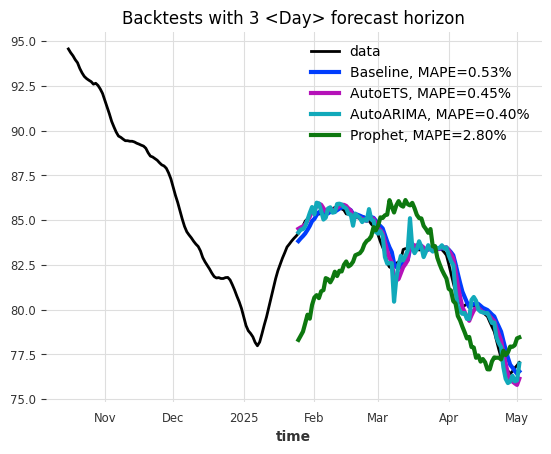

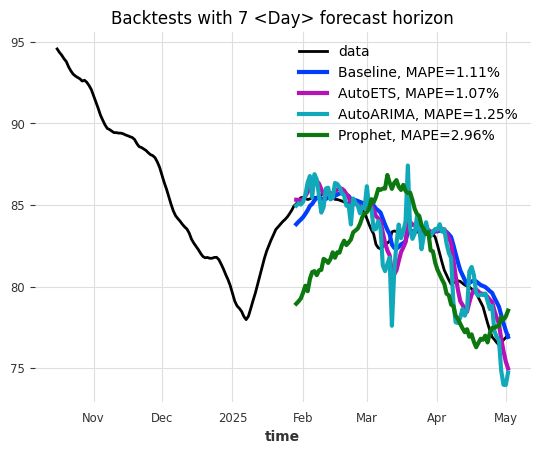

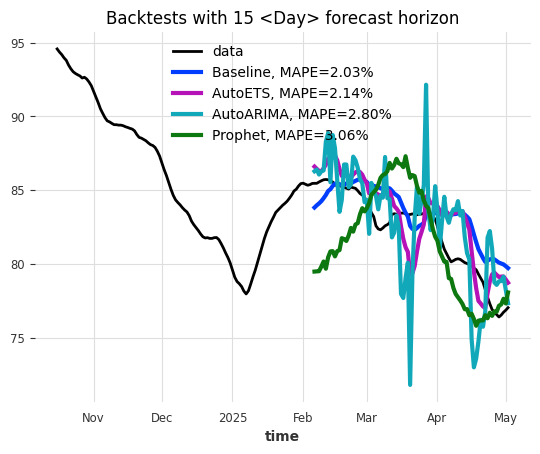

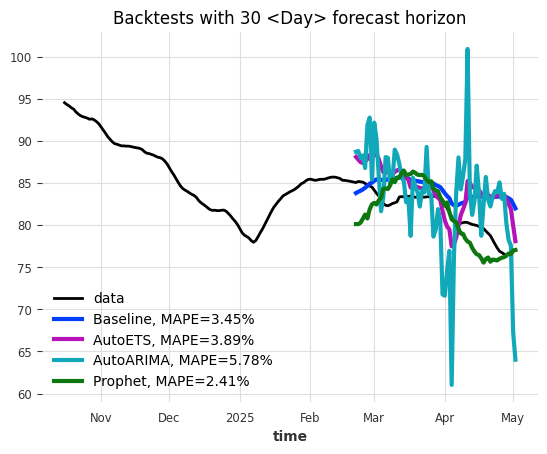

In [39]:
plot_backtest_results(series, results)

In [42]:
aarima_bic = AutoARIMA(trace=True, ic="bic")
aarima_bic = aarima_bic.fit(train)
aarima_bic.model_name = "AutoARIMA - BIC"

aarima_aicc = AutoARIMA(trace=True, ic="aicc")
aarima_aicc = aarima_aicc.fit(train)
aarima_aicc.model_name = "AutoARIMA - AICC"


ARIMA(2,2,2)                   :inf

ARIMA(0,2,0)                   :-1576.0408951297502

ARIMA(1,2,0)                   :-1572.9572920349783

ARIMA(0,2,1)                   :-1572.4655852511605

ARIMA(1,2,1)                   :-1571.2018590318287
Now re-fitting the best model(s) without approximations...


ARIMA(0,2,0)                   :-1576.0408951297502

ARIMA(2,2,2)                   :inf

ARIMA(0,2,0)                   :-1581.544735877338

ARIMA(1,2,0)                   :-1583.962768462499

ARIMA(0,2,1)                   :-1583.4710616786813

ARIMA(2,2,0)                   :-1589.5474892514517

ARIMA(3,2,0)                   :-1595.6697334038981

ARIMA(4,2,0)                   :-1598.020444215008

ARIMA(5,2,0)                   :-1596.2323227853858

ARIMA(4,2,1)                   :-1658.5068596603742

ARIMA(3,2,1)                   :-1595.4252177759035

ARIMA(5,2,1)                   :-1642.5006327561073

ARIMA(4,2,2)                   :-1729.5931157459204

ARIMA(3,2,2)        

In [43]:
results = backtest_models(series, models=[aarima_bic, aarima_aicc], retrain=False, horizons=horizons)

Backtesting 1 <Day> horizon
Backtesting AutoARIMA - BIC


historical forecasts:   0%|          | 0/100 [00:00<?, ?it/s]

Backtesting AutoARIMA - AICC


historical forecasts:   0%|          | 0/100 [00:00<?, ?it/s]

Backtesting 3 <Day> horizon
Backtesting AutoARIMA - BIC


historical forecasts:   0%|          | 0/98 [00:00<?, ?it/s]

Backtesting AutoARIMA - AICC


historical forecasts:   0%|          | 0/98 [00:00<?, ?it/s]

Backtesting 7 <Day> horizon
Backtesting AutoARIMA - BIC


historical forecasts:   0%|          | 0/94 [00:00<?, ?it/s]

Backtesting AutoARIMA - AICC


historical forecasts:   0%|          | 0/94 [00:00<?, ?it/s]

Backtesting 15 <Day> horizon
Backtesting AutoARIMA - BIC


historical forecasts:   0%|          | 0/86 [00:00<?, ?it/s]

Backtesting AutoARIMA - AICC


historical forecasts:   0%|          | 0/86 [00:00<?, ?it/s]

Backtesting 30 <Day> horizon
Backtesting AutoARIMA - BIC


historical forecasts:   0%|          | 0/71 [00:00<?, ?it/s]

Backtesting AutoARIMA - AICC


historical forecasts:   0%|          | 0/71 [00:00<?, ?it/s]

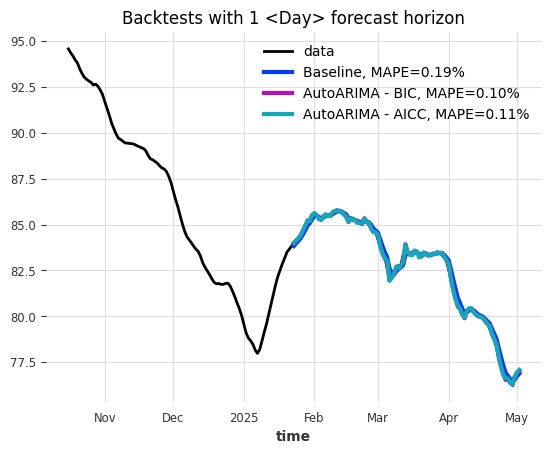

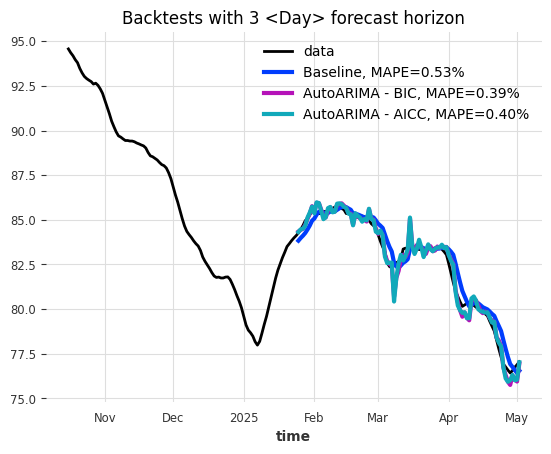

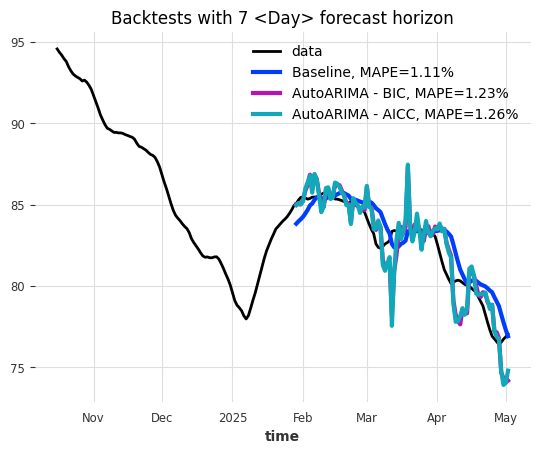

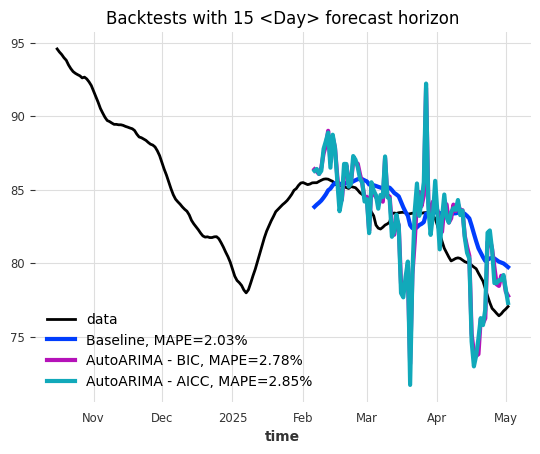

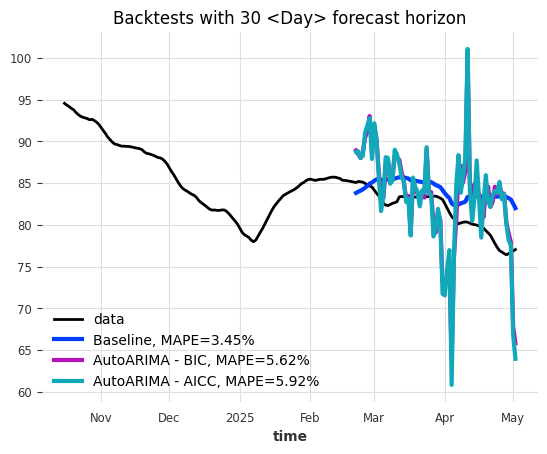

In [44]:
plot_backtest_results(series, results)

In [45]:
horizon = [7]

In [46]:
from darts.models import AutoETS

In [47]:
def ETS_optimize(trial: optuna.Trial, series: TimeSeries=series, single_horizon: list=horizon):
    params={
        "season_length": trial.suggest_int("ets_season_length", 1, 365),
        "model": trial.suggest_categorical("ets_e", ["M", "A", "Z"]) + trial.suggest_categorical("ets_t", ["N", "M", "A", "Z"]) + trial.suggest_categorical("ets_s", ["N", "M", "A", "Z"]),
    }
    
    model = AutoETS(**params)
    results = backtest_models(
        series, 
        models=[model], 
        horizons=single_horizon,
        points_to_test=50,
        verbose=False,
    )
    return results[single_horizon[0]][str(model)][1]

In [49]:
model_list = [
    "AutoETS",
    "AutoARIMA",
    "Prophet",
]
model_family = model_list[0]

In [50]:
# Create optuna study with defined function and storage
study = optuna.create_study(
    direction="minimize",
    storage=storage,
    study_name=f"{series_name}_{horizon[0]}_{model_family}_study",
    load_if_exists=True
)

[I 2025-05-12 21:43:34,158] A new study created in Journal with name: Job_Postings_7_AutoETS_study


In [51]:
from darts.ad import KMeansScorer

scorer = KMeansScorer(k=2, window=5)
scorer.fit(train)
anom_score = scorer.score(val)

In [52]:
from darts.ad import QuantileDetector

detector = QuantileDetector(high_quantile=0.99)
detector.fit(scorer.score(train))
binary_anom = detector.detect(anom_score)

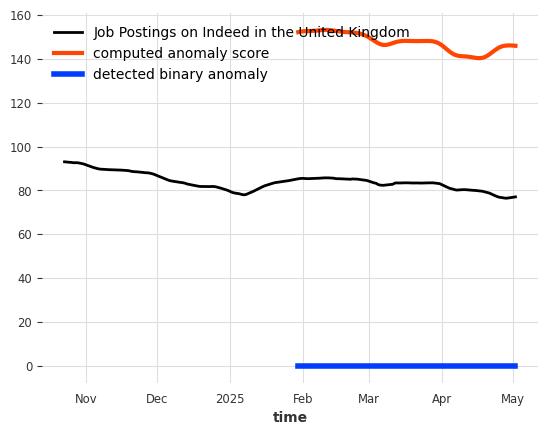

In [53]:
series.drop_before(visualizing).plot()
(anom_score + 1.5 * max(series.drop_before(visualizing))).plot(label="computed anomaly score", c="orangered", lw=3)
(binary_anom * .5 * max(series.drop_before(visualizing))).plot(label="detected binary anomaly", lw=4)
plt.show()